[2018-Local Density Estimation in High Dimensions](http://proceedings.mlr.press/v80/wu18a/wu18a.pdf) By Xian Wu, [Moses Charikar](https://profiles.stanford.edu/moses-charikar), and [Vishnu Natchu](https://dblp.org/pers/hd/n/Natchu:Vishnu)

In [1]:
import numpy as np

from sklearn import datasets
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances

import math

import matplotlib.pyplot as plt

from scipy.spatial import distance

mbyte = 1048576
norm_l1 = Normalizer(norm='l1')
norm_l2 = Normalizer(norm='l2')

In [545]:
import seaborn as sns

# Datasets

In [2]:
%store -r Datasets
data = Datasets['SIFT-10K']
train = data['train']
test = data['test']
n_train = data['n_train']
n_test = data['n_test']
print(data.keys())

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])


# Tools

In [378]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [4]:
def build_k_combinations(k):
    kwargs = np.repeat([0, 1], k).reshape(2, -1).T
    return np.array(np.meshgrid(*kwargs)).T.reshape(-1, k)

In [6]:
%%time
build_k_combinations(9)

CPU times: user 387 µs, sys: 93 µs, total: 480 µs
Wall time: 436 µs


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [5]:
def str_to_list(s):
    return np.array(s[1:-1].split(' ')).astype(np.int)

# Test Normalized

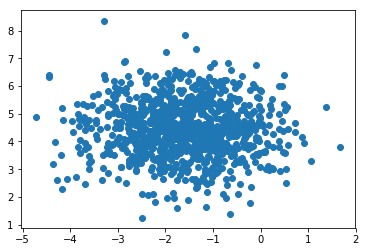

In [7]:
P = datasets.make_blobs(centers=1, n_features=2, n_samples=1000, random_state=1)[0]
plt.scatter(P[:, 0], P[:, 1])

**center the mean**

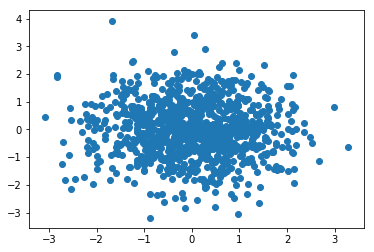

In [8]:
P = P - P.mean(axis=0)
plt.scatter(P[:, 0], P[:, 1])

**test angle function**

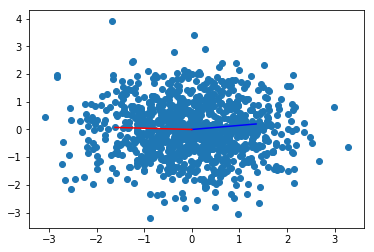

In [9]:
p1 = P[1]
p2 = P[4]
plt.scatter(P[:, 0], P[:, 1])
plt.plot([0, p1[0]], [0, p1[1]], c='b')
plt.plot([0, p2[0]], [0, p2[1]], c='r')
plt.show()

In [10]:
angle_between(p1, p2) / np.pi * 180

169.02810957690866

**normlize**

(-1.1098521966751331,
 1.1098548391224843,
 -1.1151663754265546,
 1.115175498699267)

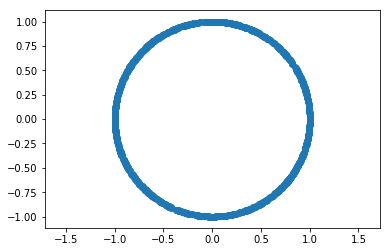

In [11]:
norm_P = norm_l2.fit_transform(P)
plt.scatter(norm_P[:, 0], norm_P[:, 1])
plt.axis('equal')

## train test

In [12]:
train, test = train_test_split(norm_P, test_size=100, random_state=1)

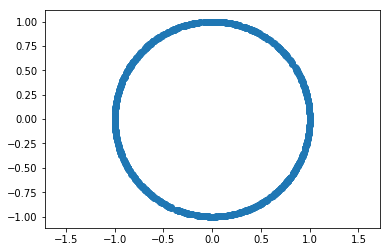

In [14]:
plt.scatter(train[:, 0], train[:, 1])
plt.axis('equal')
plt.show()

**target**

1. preprocessing the dataset
1. given query q, and a range of angles of interest A
2. estimate the number of elements that the angles are within range A

In [416]:
q = P[0]
A = np.pi / 5

In [413]:
idxs = np.argwhere(np.array([angle_between(q, p) for p in P]) <= A).reshape(1, -1)[0]

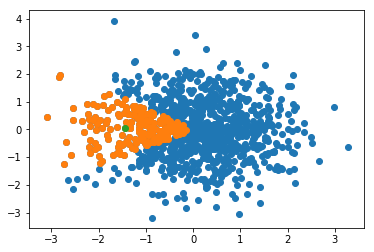

In [414]:
plt.scatter(P[:, 0], P[:, 1])
plt.scatter(P[idxs, 0], P[idxs, 1])
plt.scatter(q[0], q[1])
plt.show()

In [415]:
len(idxs)

201

# LSH Count

In [23]:
from scipy.special import comb, perm

$$
p(x) = \Bbb{P}(d_{qx} = i | \theta_{qx}) = {k \choose i} \
(1 - {\theta_{qx} \over \pi})^{k-i} \
({\theta_{qx} \over \pi})^i
$$

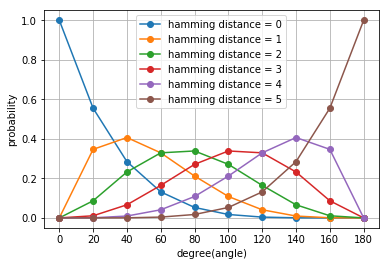

In [24]:
k = 5 # length of hash code
pi = 180
theta = np.linspace(start=0, stop=180, num=10)
for i in range(k + 1):
    pr = comb(k, i) * (( 1 - theta / pi) ** (k - i)) * ((theta / pi) ** i)
    plt.plot(theta, pr, 'o-', label='hamming distance = {}'.format(i))

plt.xticks(theta)
plt.grid()
plt.legend()
plt.xlabel('degree(angle)')
plt.ylabel('probability')
plt.show()

## Hashing

In [417]:
v = np.random.normal(0, 1, (2))
H = train.dot(v)
H[H >= 0] = 1
H[H < 0] = 0
H = H.astype(np.int8)

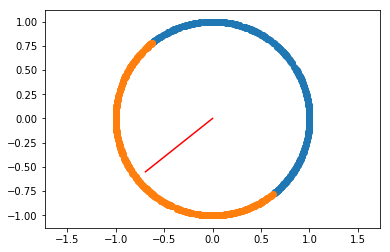

In [428]:
plt.scatter(train[H==0, 0], train[H==0, 1])
plt.scatter(train[H==1, 0], train[H==1, 1])
plt.plot([0, v[0]], [0, v[1]], c='r')
plt.axis('equal')
plt.show()

In [25]:
def hashing(q, V):
    H = np.array([q.dot(v.T) for v in V])
    H[H >= 0] = 1
    H[H < 0] = 0
    H = H.astype(np.int8)
    return H

## Hash Tables

$$
g(v) = (h_1(v), ..., h_k(v)) \\
G = g_1, g_2, ..., g_L
$$

**bit-wise hash**

$$
h_r(v) = 
\begin{cases}
0, & \text{if }r\cdot v \le 0 \\
1, & \text{otherwise}
\end{cases}
$$

In [474]:
def construct_hash_tables(P, k, L, random_state=None):
    
    if random_state is None:
        rand = np.random.RandomState()
    else:
        rand = np.random.RandomState(random_state)
    
    n, d = P.shape
    
    V = np.array([rand.normal(0, 1, (k, d)) for i in range(L)])
    
    hash_tables = []
    
    for i in range(L):
        # hashing
        H = P.dot(V[i].T)
        H[H >= 0] = 1
        H[H < 0] = 0
        H = H.astype(np.int8)
        
        # get unique key
        keys = np.unique(H, axis=0)

        # buckets
        buckets = dict()
        
        for key in keys:
            buckets[str(key)] = []
            
        for j, h in enumerate(H):
            buckets[str(h)].append(j)

        hash_tables.append(buckets)
    
    return hash_tables, V

In [475]:
%%time
k = 7
L = 10
random_state = 1

hash_tables, V = construct_hash_tables(train, k, L, random_state)

CPU times: user 400 ms, sys: 3.32 ms, total: 404 ms
Wall time: 402 ms


In [28]:
# str_list -> array
# np.array(list(map(str_to_list, list(hash_tables[0].keys()))))

## Counts Vector

### normal

In [431]:
def construct_count_tables(hash_tables):
    
    count_tables = []
    
    for hash_table in hash_tables: # L hash table
        count_table = dict()
        
        str_keys = list(hash_table.keys()) # keys of hash table is string eg. '[0 0 0]'
        arr_keys = np.array(list(map(str_to_list, str_keys))) # string to array 
                                                              # eg. '[0 0 0]' -> [0, 0, 0]
        
        for key in str_keys:
            count_table[key] = dict() # indexing
        
        for i, str_key in enumerate(str_keys):
            arr_key = arr_keys[i] # array  eg. [0, 0, 0]
            
            # self count
            count_table[str_key][0] = [(str_key, len(hash_table[str_key]))]
            
            for j in range(i + 1, len(str_keys)): # hamming distance starts from 1 
                arr_candidate_key = arr_keys[j]
                str_candidate_key = str_keys[j]
                
                dis = np.sum(np.abs(arr_key - arr_candidate_key))
                
                if dis not in count_table[str_key]:
                    count_table[str_key][dis] = [(str_candidate_key, 
                                                  len(hash_table[str_candidate_key]))] 
                                                # (hashing, number)
                else:
                    count_table[str_key][dis].append((str_candidate_key, 
                                                      len(hash_table[str_candidate_key])))
                    
                if dis not in count_table[str_candidate_key]:
                    count_table[str_candidate_key][dis] = [(str_key, len(hash_table[str_key]))]
                else:
                    count_table[str_candidate_key][dis].append((str_key, len(hash_table[str_key])))
        
        count_tables.append(count_table)
        
    return count_tables

In [433]:
%%time
count_tables = construct_count_tables(hash_tables)

CPU times: user 11.1 ms, sys: 3.3 ms, total: 14.4 ms
Wall time: 27.6 ms


In [434]:
for key, value in count_tables[0].items():
    print(key)
    print(value)
    break

[0 0 0 0 0 0 0]
{0: [('[0 0 0 0 0 0 0]', 178)], 1: [('[0 0 0 0 0 0 1]', 41), ('[1 0 0 0 0 0 0]', 8)], 2: [('[0 1 0 0 0 0 1]', 113), ('[1 0 0 1 0 0 0]', 32)], 3: [('[0 1 1 0 0 0 1]', 39), ('[1 0 0 1 1 0 0]', 37)], 4: [('[0 1 1 0 0 1 1]', 46), ('[1 0 0 1 1 1 0]', 30)], 5: [('[0 1 1 0 1 1 1]', 29), ('[1 0 1 1 1 1 0]', 119)], 6: [('[0 1 1 1 1 1 1]', 5), ('[1 1 1 1 1 1 0]', 51)], 7: [('[1 1 1 1 1 1 1]', 172)]}


### aggregate-counts

In [32]:
def aggregate_counts(hash_tables, k):
    count_tables = []
    
    N = dict()
    combinations = build_k_combinations(k)
    for key in combinations:
        N[str(key)] = []
        n_keys = combinations[np.sum(np.abs(combinations - key), axis=1) == 1]
        for n_key in n_keys:
            N[str(key)].append(str(n_key))
        
    for hash_table in hash_tables:
        
        count_table = dict()

        for key in combinations:
            count_table[str(key)] = dict()

        for r in range(k + 1):
            for key in combinations:
                str_key = str(key)
                if r == 0:
                    if str_key in hash_table:
                        count_table[str_key][r] = len(hash_table[str_key])
                    else:
                        count_table[str_key][r] = 0
            
                else:
                    for n_key in N[str_key]:
                        if r not in count_table[str_key]:
                            count_table[str_key][r] = count_table[n_key][r - 1]
                        else:
                            count_table[str_key][r] += count_table[n_key][r - 1]
                    
                    if r != 1:
                        count_table[str_key][r] -= ((k - r + 2) * count_table[str_key][r - 2])
                        count_table[str_key][r] /= r
        
        str_keys = list(hash_table.keys())
        temp = dict()
        for key in str_keys:
            temp[key] = count_table[key]
        
        count_tables.append(temp)
    
    return count_tables

## Sampler

### normal

In [445]:
def construct_sample_table(H, hash_tables, count_tables, I, n_samples):
    sample_table = dict()   

    candidates = []
    count = 0
    
    for l, h in enumerate(H):
        if str(h) in count_tables[l]: # hash code in tables
            for i in I:
                if i in count_tables[l][str(h)]:
                    for key, number in count_tables[l][str(h)][i]:
                        candidates.append(hash_tables[l][key])
                        count += number
    
    count /= len(hash_tables)
    candidates = np.concatenate(np.array(candidates))
    
#     idx_samples = np.random.choice(candidates, size=n_samples, replace=False)
    samples = np.random.choice(candidates, size=n_samples, replace=True)
    
    sample_table['count'] = count
    sample_table['candidates'] = candidates
    sample_table['samples'] = samples
    sample_table['n_samples'] = n_samples
    sample_table['I'] = I
    
    return sample_table

In [446]:
q = test[0]
H = hashing(q, V)

In [463]:
I = [0, 1]
n_samples = 200

sample_table = construct_sample_table(H, hash_tables, count_tables, I, n_samples)

In [464]:
sample_table

{'count': 208.3,
 'candidates': array([ 30,  33,  35, ..., 889, 891, 895]),
 'samples': array([457, 602, 353, 268, 231, 545, 607, 457, 423, 502, 575, 513,   1,
        720, 746, 448, 230, 418, 834,  47, 472, 229, 142, 134,   9, 641,
        359, 747, 466, 116, 453, 497,  47, 233,  51,  70, 528, 240, 899,
        784, 522, 719, 211, 392, 484, 665, 449,  82, 876, 403, 201, 325,
        517, 692, 280, 812, 373, 387, 569,  97, 261, 734, 395, 784, 197,
        375, 607, 621, 493, 713, 406,  74, 474, 542, 538, 513, 761, 375,
         69,  68,  30, 474, 150, 300, 625, 658, 108, 168, 538, 192, 814,
        847, 471,  78, 247, 395, 208, 192, 513, 221, 805, 476, 230, 545,
        286, 831, 598, 794, 293,  78, 769, 450, 412, 471, 768, 693, 118,
         88, 784, 835, 545, 118, 397, 871, 449, 714, 128, 538, 533, 345,
        630, 774, 812, 387, 661, 659,  93,  26,  93,  52, 211, 734, 784,
         54, 395,  12, 208, 661, 693, 720,  47,  72, 510, 794, 470, 590,
        362,  89, 550,  88,   9, 535,

### hamming-distance-sampler (ERROR)

In [ ]:
a = np.array([0, 0, 1])

In [ ]:
mask = np.array([1, 0, 0])

In [ ]:
mask ^ a

In [ ]:
def counts_matrix(count_tables, k):
    Ms = []
    for count_table in count_tables:
        M = dict()
        for key, items in count_table.items():
            M[key] = np.zeros((k + 1, k + 1))
            M[key][0][k] = items[0][0][1]
            
            arr_key = str_to_list(key)
            
            for hamming_distance, keys_counts in items.items():
                if hamming_distance == 0:
                    continue
                for key_count in keys_counts:
                    arr_candidate_key = str_to_list(key_count[0])
                    a = np.argwhere(arr_key != arr_candidate_key)[0][0]
                    M[key][hamming_distance][a] += key_count[1]
            
        Ms.append(M)
    
    return Ms

In [ ]:
M = counts_matrix(count_tables, k)

In [ ]:
def hamming_distance_sampler(H, hash_tables, k, i, M):
    mask = np.zeros(k).astype(np.int8)
    g = 0
    for j, hash_table in enumerate(hash_tables):
        h = H[j]
        for r in range(k):
            if g < i:
                h1 = h ^ mask
                h2 = h1 ^ np.append(np.append(np.repeat(0, r), 1), np.repeat(0, k-r-1))
                str_h1 = str(h1)
                str_h2 = str(h2)
                
                if str_h2 in M[j]:
                    if str_h1 in M[j]:
                        pr = M[j][str_h2][i - g - 1, r + 1] / (M[j][str_h2][i - g - 1, r + 1] + 
                                                               M[j][str_h1][i - g, r + 1])
                    else:
                        pr = 1
                else:
                    continue
                
                f = np.random.choice([1, 0], p=[pr, 1 - pr])
                if f == 1:
                    g += 1
                    mask = mask ^ np.append(np.append(np.repeat(0, r), 1), np.repeat(0, k-r-1))
        
        print(h ^ mask)

In [ ]:
q = test[0]
H = hashing(q, V)

In [ ]:
H

In [ ]:
hamming_distance_sampler(H, hash_tables, k, 1, M)

## Estimator

$$
Z = 
\begin{cases}
\frac{\sum_{l=1}^{L}C_q^l(\cal{I})}{L\cdot p(x)} &, \text{if } \theta_{qx} \in \cal{A} \\
0 &, \text{otherwise}
\end{cases} \\
\text{where }p(x) = \Bbb{P}(d_{qx}\in \cal{I} |\theta_{qx}) \ 
= \sum_{i \in I}\Bbb{P}(d_qx = i|\theta_{qx}) \\
$$
$$
\text{Estimator} = \frac{\sum_{i=1}^S Z_i}{S}
$$

In [449]:
def estimate(P, q, k, A, sample_table):
    Z = 0
    for idx in sample_table['samples']:
        theta_qx = angle_between(q, P[idx])
        if theta_qx <= A:
            px = 0
            for i in sample_table['I']:
                px += comb(k, i) * (( 1 - theta_qx / np.pi) ** (k - i)) * ((theta_qx / np.pi) ** i)
            Z += (sample_table['count'] / px)

    return Z / sample_table['n_samples']

## Test

### Test Algorithm

In [476]:
%%time
k = 7
L = 10
A = np.pi / 4
random_state = 1

hash_tables, V = construct_hash_tables(train, k, L, random_state)
count_tables = construct_count_tables(hash_tables)

CPU times: user 428 ms, sys: 6.66 ms, total: 434 ms
Wall time: 422 ms


In [478]:
%%time
real_density = []
for q in test:
    real_density.append(sum(np.array([angle_between(q, p) for p in train]) <= (A)))

CPU times: user 1.79 s, sys: 93.2 ms, total: 1.89 s
Wall time: 1.81 s


In [481]:
%%time
n_samples = 200

I = [0, 1, 2]

estimate_density = []

for q in test:
    H = hashing(q, V)
    sample_table = construct_sample_table(H, hash_tables, count_tables, I, n_samples)
    estimate_density.append(estimate(train, q, k, A, sample_table))

CPU times: user 1.11 s, sys: 6.62 ms, total: 1.12 s
Wall time: 1.12 s


In [482]:
estimate_density = np.array(estimate_density).astype(np.int)

In [483]:
(np.abs(estimate_density - real_density) / real_density).mean()

0.0568522652854725

## W

$$
W = {1 \over L}\sum_{l=1}^L\sum_{x\in\cal A_q} \
\frac{\Bbb1(x\in \cal B^l_q(\cal I))}{p(x)} \\
\text{where }p(x) = \Bbb P(d_{qx}\in \cal I |\theta_{qx}) \ 
= \sum_{i \in I}\Bbb P(d_qx = i|\theta_{qx})
$$

$$
\begin{align}
E(W) &= {1\over L}\sum_{l=1}^L\sum_{x\in \cal A_q} \
\frac{E(\Bbb1(x\in\cal B^l_q(\cal I)))}{p(x)} \\
&= |\cal A_q|
\end{align}
$$

In [495]:
def calculate_W(P, q, k, A, sample_table):
    W = 0
    for idx in sample_table['candidates']:
        theta_qx = angle_between(q, P[idx])
        if theta_qx <= A:
            px = 0
            for i in sample_table['I']:
                px += comb(k, i) * (( 1 - theta_qx / np.pi) ** (k - i)) * ((theta_qx / np.pi) ** i)
            W += (1 / px)
    return W / L


### Test W

In [498]:
%%time
I = [0, 1, 2]
estimate_W = []
for q in test:
    H = hashing(q, V)
    sample_table = construct_sample_table(H, hash_tables, count_tables, I, n_samples)
    estimate_W.append(calculate_W(train, q, k, A, sample_table))

CPU times: user 12.9 s, sys: 93.4 ms, total: 13 s
Wall time: 12.9 s


In [499]:
estimate_W = np.array(estimate_W).astype(np.int)
(np.abs(estimate_W - real_density) / real_density).mean()

0.03734922534322747

## Algorithm

In [536]:
class LSHEstimateDensity(object):
    """
    Given a dataset P and a query q, 
    Estimate the number of points within a specified angular distance.
    """
    def __init__(self, P, k, L, random_state=None):
        """
        Desc:
            init function
        Param:
            P: set of vectors
            k: length of hash code
            L: number of hash tables
            random_state
        """
        self._P = P
        self._k = k
        self._L = L
        self._n, self._d = P.shape
        
        if random_state is not None:
            self._rand = np.random.RandomState(random_state)
        else:
            self._rand = np.random.RandomState(random_state)
        
    def _hashing(self, q, V):
        H = np.array([q.dot(v.T) for v in V])
        H[H >= 0] = 1
        H[H < 0] = 0
        H = H.astype(np.int8)
        return H
    
    def _construct_hash_tables(self):
        rand = self._rand
        k = self._k
        L = self._L
        n = self._n
        d = self._d
        P = self._P

        V = np.array([rand.normal(0, 1, (k, d)) for i in range(L)])

        hash_tables = []

        for i in range(L):
            # hashing
            H = P.dot(V[i].T)
            H[H >= 0] = 1
            H[H < 0] = 0
            H = H.astype(np.int8)

            # get unique key
            keys = np.unique(H, axis=0)

            # buckets
            buckets = dict()

            for key in keys:
                buckets[str(key)] = []

            for j, h in enumerate(H):
                buckets[str(h)].append(j)

            hash_tables.append(buckets)

        return hash_tables, V

    def _construct_count_tables(self, hash_tables):
        
        count_tables = []

        for hash_table in hash_tables: # L hash table
            count_table = dict()

            str_keys = list(hash_table.keys()) # keys of hash table is string eg. '[0 0 0]'
            arr_keys = np.array(list(map(str_to_list, str_keys))) # string to array 
                                                                  # eg. '[0 0 0]' -> [0, 0, 0]

            for key in str_keys:
                count_table[key] = dict() # indexing

            for i, str_key in enumerate(str_keys):
                arr_key = arr_keys[i] # array  eg. [0, 0, 0]

                # self count
                count_table[str_key][0] = [(str_key, len(hash_table[str_key]))]

                for j in range(i + 1, len(str_keys)): # hamming distance starts from 1 
                    arr_candidate_key = arr_keys[j]
                    str_candidate_key = str_keys[j]

                    dis = np.sum(np.abs(arr_key - arr_candidate_key))

                    if dis not in count_table[str_key]:
                        count_table[str_key][dis] = [(str_candidate_key, 
                                                      len(hash_table[str_candidate_key]))] 
                                                    # (hashing, number)
                    else:
                        count_table[str_key][dis].append((str_candidate_key, 
                                                          len(hash_table[str_candidate_key])))

                    if dis not in count_table[str_candidate_key]:
                        count_table[str_candidate_key][dis] = [(str_key, len(hash_table[str_key]))]
                    else:
                        count_table[str_candidate_key][dis].append((str_key, len(hash_table[str_key])))

            count_tables.append(count_table)

        return count_tables
    
    def preprocessing(self):
        self.hash_tables, self.V = self._construct_hash_tables()
        self.count_tables = self._construct_count_tables(self.hash_tables)
    
    def _construct_sample_table(self, H, hash_tables, count_tables, I, n_samples=1):
        rand = self._rand
        
        sample_table = dict()   

        candidates = []
        count = 0

        for l, h in enumerate(H):
            if str(h) in count_tables[l]: # hash code in tables
                for i in I:
                    if i in count_tables[l][str(h)]:
                        for key, number in count_tables[l][str(h)][i]:
                            candidates.append(hash_tables[l][key])
                            count += number

        count /= len(hash_tables)
        candidates = np.concatenate(np.array(candidates))

    #     idx_samples = np.random.choice(candidates, size=n_samples, replace=False)
        samples = rand.choice(candidates, size=n_samples, replace=True)

        sample_table['count'] = count
        sample_table['candidates'] = candidates
        sample_table['samples'] = samples
        sample_table['n_samples'] = n_samples
        sample_table['I'] = I

        return sample_table
    
    def estimate(self, q, A, I=[0], n_samples=100):
        """
        Desc:
            given a query q, 
            estimate the number of points within Angular distance A of q.
        
        Param:
            q: query
            I: set of hamming distance
               default: [0]
            A: angular distance
               default: np.pi / 3
            n_samples: number of samples.
               default: 100
        
        Return:
            the number of points within Angular distance A of q 
        """
        P = self._P
        k = self._k
        
        H = hashing(q, self.V)
        
        sample_table = self._construct_sample_table(H, self.hash_tables, self.count_tables, I, n_samples)
        
        Z = 0
        for idx in sample_table['samples']:
            theta_qx = angle_between(q, P[idx])
            if theta_qx <= A:
                px = 0
                for i in sample_table['I']:
                    px += comb(k, i) * (( 1 - theta_qx / np.pi) ** (k - i)) * ((theta_qx / np.pi) ** i)
                Z += (sample_table['count'] / px)

        return Z / sample_table['n_samples']
    
    def calculate_W(self, q, A, I):
        W = 0
        k = self._k
        P = self._P
        L = self._L
        
        H = hashing(q, self.V)
        sample_table = self._construct_sample_table(H, self.hash_tables, self.count_tables, I)
        
        for idx in sample_table['candidates']:
            theta_qx = angle_between(q, P[idx])
            if theta_qx <= A:
                px = 0
                for i in sample_table['I']:
                    px += comb(k, i) * (( 1 - theta_qx / np.pi) ** (k - i)) * ((theta_qx / np.pi) ** i)
                W += (1 / px)
                
        return W / L

### test

#### test points

In [503]:
train, test = train_test_split(norm_P, test_size=100, random_state=1)

In [504]:
%%time
A = np.pi / 4
real_density = []
for q in test:
    real_density.append(sum(np.array([angle_between(q, p) for p in train]) <= (A)))

CPU times: user 1.79 s, sys: 63.3 ms, total: 1.86 s
Wall time: 1.77 s


In [537]:
%%time
k = 7
L = 10
random_state = 1

estimator = LSHEstimateDensity(train, k, L, random_state)

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 23.4 µs


In [538]:
%%time
estimator.preprocessing()

CPU times: user 459 ms, sys: 1 µs, total: 459 ms
Wall time: 455 ms


In [542]:
I = [0, 1]
n_samples = 100
estimate_density = []

for q in test:
    estimate_density.append(
        estimator.estimate(q, A, I, n_samples)
#         estimator.calculate_W(q, A, I)
    )

In [544]:
(np.abs((np.round(np.array(estimate_density)) - real_density)) / real_density).mean()

0.07689337668190699

#### test SIFT

In [47]:
%store -r Datasets
data = Datasets['SIFT-10K']
train = data['train']
test = data['test']
n_train = data['n_train']
n_test = data['n_test']
print(data.keys())

dict_keys(['title', 'train', 'test', 'K', 'n_train', 'n_test', 'k_near_neighbors', 'nearest_neighbor'])


In [504]:
%%time
A = np.pi / 4
real_density = []
for q in test:
    real_density.append(sum(np.array([angle_between(q, p) for p in train]) <= (A)))

CPU times: user 1.79 s, sys: 63.3 ms, total: 1.86 s
Wall time: 1.77 s


In [537]:
%%time
k = int(np.round(np.log(train.shape[0]))
L = 20
random_state = 1
print(A, k, L)

estimator = LSHEstimateDensity(train, k, L, random_state)

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 23.4 µs


In [538]:
%%time
estimator.preprocessing()

CPU times: user 459 ms, sys: 1 µs, total: 459 ms
Wall time: 455 ms


In [542]:
I = [0, 1, 2, 3]
n_samples = 1000
estimate_density = []

for q in test:
    estimate_density.append(
        estimator.estimate(q, A, I, n_samples)
#         estimator.calculate_W(q, A, I)
    )

In [52]:
(np.abs((np.round(np.array(estimate_density)) - real_density)) / real_density).mean()

0.11507596153389507

### params

- **k** 
    - fix $k = np.log(n)$
- **L**
- **n_samples**
- **I**

In [551]:
%%time
k = 7
random_state = 1
I = [0]

error_ratios = [] # (L, n_samples)

for i, L in enumerate(range(10, 110, 10)):
    estimator = LSHEstimateDensity(train, k, L, random_state)
    estimator.preprocessing()
    error_ratios.append([])
    
    for n_samples in range(100, 1050, 50):
        temp = []
        for j in range(10):
            estimate_density = []
            for q in test:
                estimate_density.append(estimator.estimate(q, A, I, n_samples))
            temp.append((np.abs((np.round(np.array(estimate_density)) - real_density)) / real_density).mean())
        error_ratios[i].append(np.array(temp).mean())

CPU times: user 3h 11min 53s, sys: 41.2 s, total: 3h 12min 35s
Wall time: 3h 14min 5s


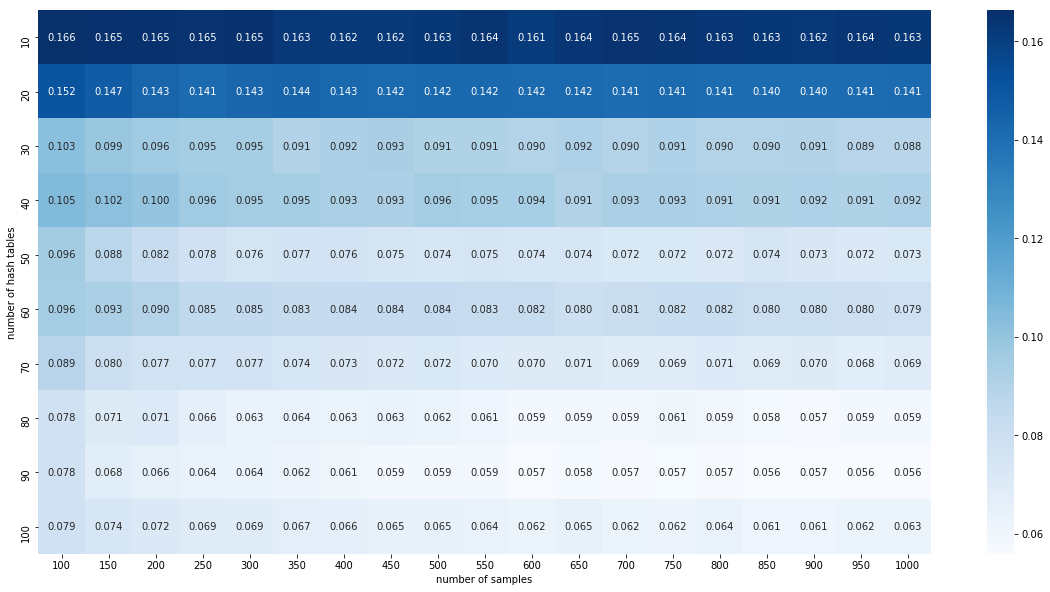

In [552]:
plt.figure(figsize=(20, 10))
sns.heatmap(error_ratios, annot=True, fmt='.3f',
            xticklabels=np.arange(100, 1050, 50),
            yticklabels=np.arange(10, 110, 10),
            cmap='Blues')
plt.xlabel('number of samples')
plt.ylabel('number of hash tables')
plt.show()

# Next Paper

## train test

In [379]:
train, test = train_test_split(norm_P, test_size=100, random_state=1)

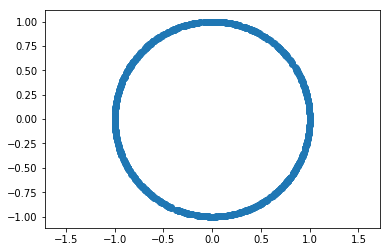

In [380]:
plt.scatter(train[:, 0], train[:, 1])
plt.axis('equal')
plt.show()

In [381]:
q = P[0]
dis = np.array([distance.euclidean(q, p) for p in P])

In [382]:
idxs_dis = np.argwhere(dis <= 0.5).reshape(1, -1)[0] # threshold = 0.5

In [383]:
len(idxs_dis)

36

In [386]:
np.array([angle_between(q, P[idx]) for idx in idxs_dis]).max() # calc the max angle of B_q

0.35336670766094497

In [387]:
idxs_angles = np.argwhere(np.array([angle_between(norm_P[0], p) for p in norm_P]) <= 0.353366).reshape(1, -1)[0]

In [388]:
len(idxs_angles)

102

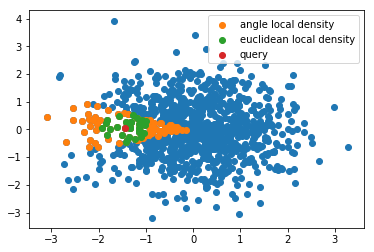

In [392]:
plt.scatter(P[:, 0], P[:, 1])
plt.scatter(P[idxs_angles, 0], P[idxs_angles, 1], label='angle local density')
plt.scatter(P[idxs_dis, 0], P[idxs_dis, 1], label='euclidean local density')
plt.scatter(q[0], q[1], label='query')
plt.legend()
plt.show()